# INF0413 - Processamento Digital de Sinais e Imagens - A03

Neste notebook decidimos aplicar o conhecimento adquirido durante o curso ao nosso problema, principalmente, nos baseando na primeira e na segunda prova. Visto que, possuímos um problema de classificação, isto é, categorizar se um determinado áudio é deepfake ou não, vamos vamos trabalhar os conceitos de FFT e STFT a fim de, ao final, gerar um modelo de detecção de deepfakes.

<img src='https://www.popsci.com/uploads/2023/08/02/Depositphotos_203233674_L.jpg?auto=webp&width=1440&height=810' alt='image by address' height='350px'>

### Imports

In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import sys
sys.path.append('/content/')
# from myAudioProcessingLib import *
import librosa

import seaborn as sns

import wave # <- Biblioteca para reproduzir arquivos WAV
from IPython.display import Audio


### Functions


In [4]:

max_amplitude = np.iinfo('uint16').max # 2**NUM_BITS-1

def audioread(filename):
    '''
       Carrega os dados do som em um arquivo e retorna os dados no array 'soundx'
       com tipo de dado 'numpy.float', junto com a frequencia de amostragem 'fs'
       Cada canal de som será uma coluna do array.
    '''
    ifile = wave.open(filename)
    channels = ifile.getnchannels()
    fs = ifile.getframerate()
    frames = ifile.getnframes()
    x = ifile.readframes(frames)
    x = np.fromstring(x, dtype='uint16')
    x = x.astype('int16')
    x = x.astype(float) / max_amplitude
    soundx = x
    if channels > 1:
        soundx = x.reshape((int(len(x) / channels), channels))

    return soundx, fs

def play(x, fs=None):
    '''
       Reproduz arquivos de Audio (WAV, OGG)
    '''
    display(Audio(data=x, rate=fs))

def playMIDI(filename):
    '''
       Reproduz um arquivo MIDI
    '''
    mf = midi.MidiFile()
    mf.open(filename)
    mf.read()
    mf.close()
    s = midi.translate.midiFileToStream(mf)
    s.show('midi')

In [5]:
def plot_2_figures(figure1, figure2, **kwargs):
    # Create a figure with two subplots
    fig, (ax1, ax2) = plt.subplots(1, 2)

    # Plot the first figure in the first subplot
    ax1.plot(figure1)
    ax1.set_title(kwargs.get('title1', 'Subplot 1'))
    ax1.set_xlabel(kwargs.get('xlegend1', 'X-axis'))
    ax1.set_ylabel(kwargs.get('ylegend1', 'Y-axis'))

    # Plot the second figure in the second subplot
    ax2.plot(figure2)
    ax2.set_title(kwargs.get('title2', 'Subplot 2'))
    ax2.set_xlabel(kwargs.get('xlegend2', 'X-axis'))
    ax2.set_ylabel(kwargs.get('ylegend2', 'Y-axis'))

    # Display the plot
    plt.show()


'''
Este código só define algumas características dos plots que iremos fazer
para ficar mais bonito e com o código mais limpo
'''
from warnings import simplefilter

simplefilter('ignore')

# Set Matplotlib defaults
plt.style.use('seaborn-whitegrid')
plt.rc('figure', autolayout=True, figsize=(12, 4))
plt.rc(
    'axes',
    labelweight='bold',
    labelsize='large',
    titleweight='bold',
    titlesize=16,
    titlepad=10,
)

%config InlineBackend.figure_format = 'retina'

## Os dados

Os dados foram coletados utilizando a voz da integrante julia dollis.

São disponibilizadas três gravações nas quais são realizados saltos de corda a diferentes distâncias dos fones de gravação. Os dados não passaram por nenhum processamento específico, no entanto, foram editados de forma a garantir que cada áudio tenha um tamanho fixo de 1 milhão de amostras, com uma frequência de amostragem de 48000, resultando em uma duração de 20.8 segundos. Além disso, os áudios foram segmentados de modo que a primeira metade não contenha a prática de pular corda, enquanto na segunda metade os saltos sejam efetivamente exeutados. Para resumir:

- 3 áudios
- 1 milhão de tamanho
- 48000 de frequência de amostragem
- 20.8 segundos de audio
- Primeira metade não estou pulando, segunda metade estou pulando

In [ ]:

!gdown 1kf5VaD3EWZGApMXWg9FVbY7-V-s1Kf-r
!gdown 16bhqqOklGBXds4VlrFtrGU9BX0ziZ7nJ
!gdown 1h83rahAWk0ZKCJj5wdqGgvJDucbYUStv

!gdown 185wKkiCKNBDN4BxBAqmXVYr0OD59E4JQ # myAudioProcessing

In [13]:
# Carregar o arquivo wav
x1, fs1 = librosa.load('/content/audio_junto_20s.wav', sr=None)
x2, fs2 = librosa.load('/content/audio_junto_20s2.wav', sr=None)
x3, fs3 = librosa.load('/content/audio_junto_20s3.wav', sr=None)


# x1 = np.load('/content/x1.npz')['arr_0']
# x2 = np.load('/content/x2.npz')['arr_0']
# x3 = np.load('/content/x3.npz')['arr_0']


# assert fs1 == fs2 == fs3

# fs = fs1
fs = 48000

## Análise exploratória

Nesta sessão, vamos investigar um pouco como uma pequena janela de tempo comporta no domínio do tempo comparado com o domínio da frequência. Mas antes disso, vamos analisar as ondas de som no áudio original.


### Visualizando os dados

Vamos dar início a nossa exploração de dados!

Mas antes, vamos criar uma função que será útil para visualização dos plots.

Além disso, vamos definir uns parametros para que os plots fiquem mais bonitos e personalizados.

Um dos primeiros conhecimentos que vemos durante a matéria foi a plotagem dos áudios.

Então, vamos ver(rsrs) a voz da Julia.

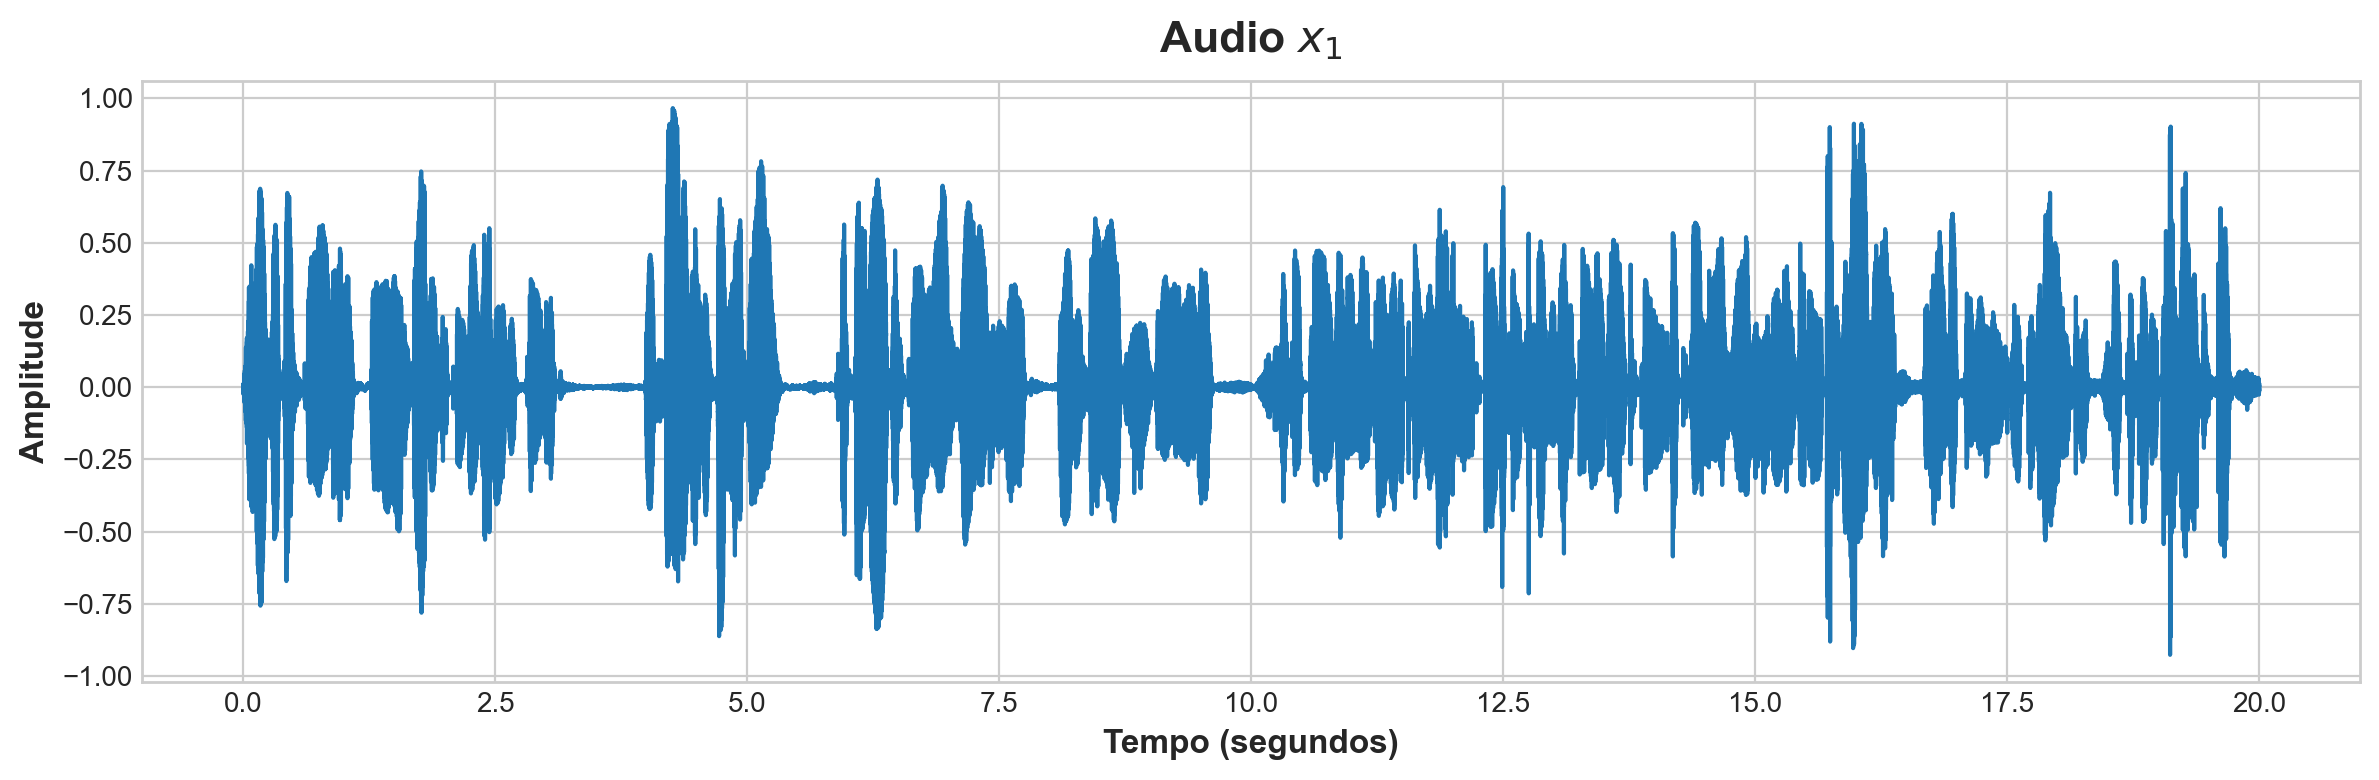

In [14]:
# Criando o vetor de tempo
N1 = len(x1)
n = np.arange(N1)
t = n / fs

# Plotagem do sinal de audio
plt.plot(t, x1)
plt.title(r'Audio $x_1$')
plt.xlabel('Tempo (segundos)')
plt.ylabel('Amplitude')
plt.show()

Assim como na A01, a primeira metade do áudio consta uma classe, nesse caso, áudio gerado, e na segunda um áudio real.

Agora, vamos ouví-los!

In [15]:
play(x1, fs)

In [16]:
play(x2, fs)

In [17]:
play(x3, fs)

E será como esses áudios ficarão se vermos eles um pouco mais de perto?

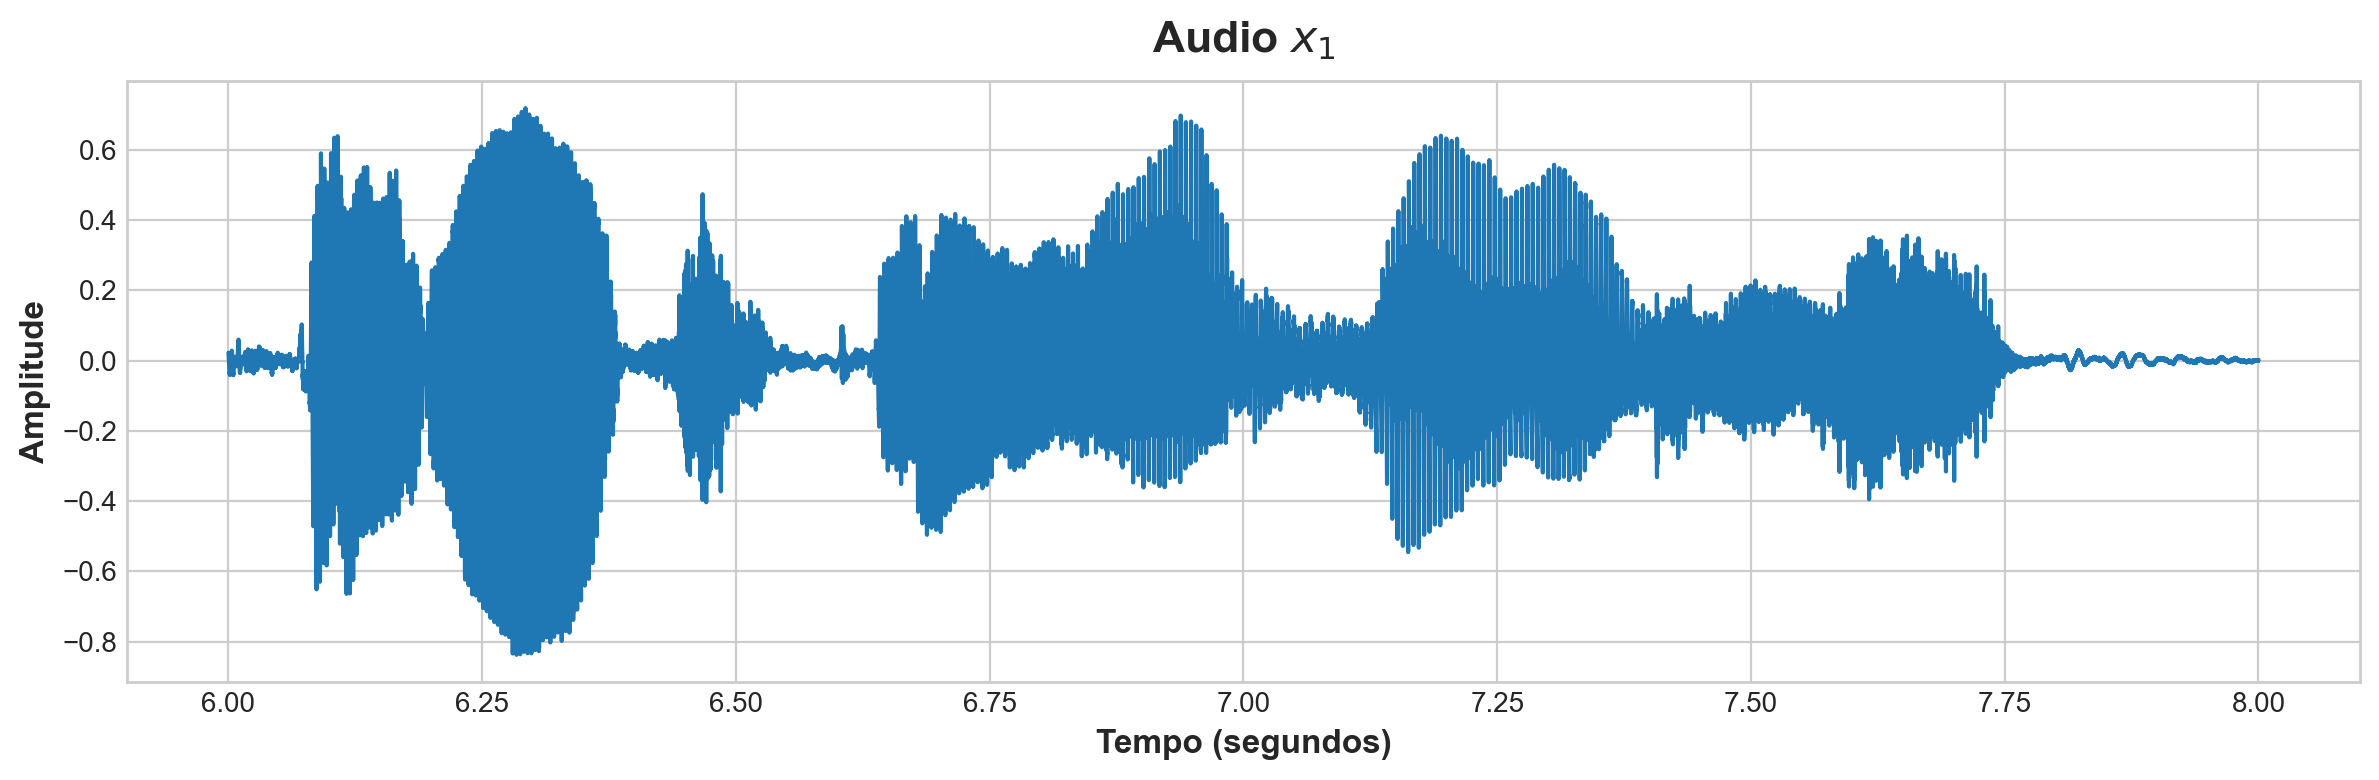

In [18]:
t = np.linspace(6, 8, fs*2)

plt.plot(t, x1[6*fs:8*fs])
plt.title(r'Audio $x_1$')
plt.xlabel('Tempo (segundos)')
plt.ylabel('Amplitude')
plt.show()

MAIS PERTO!

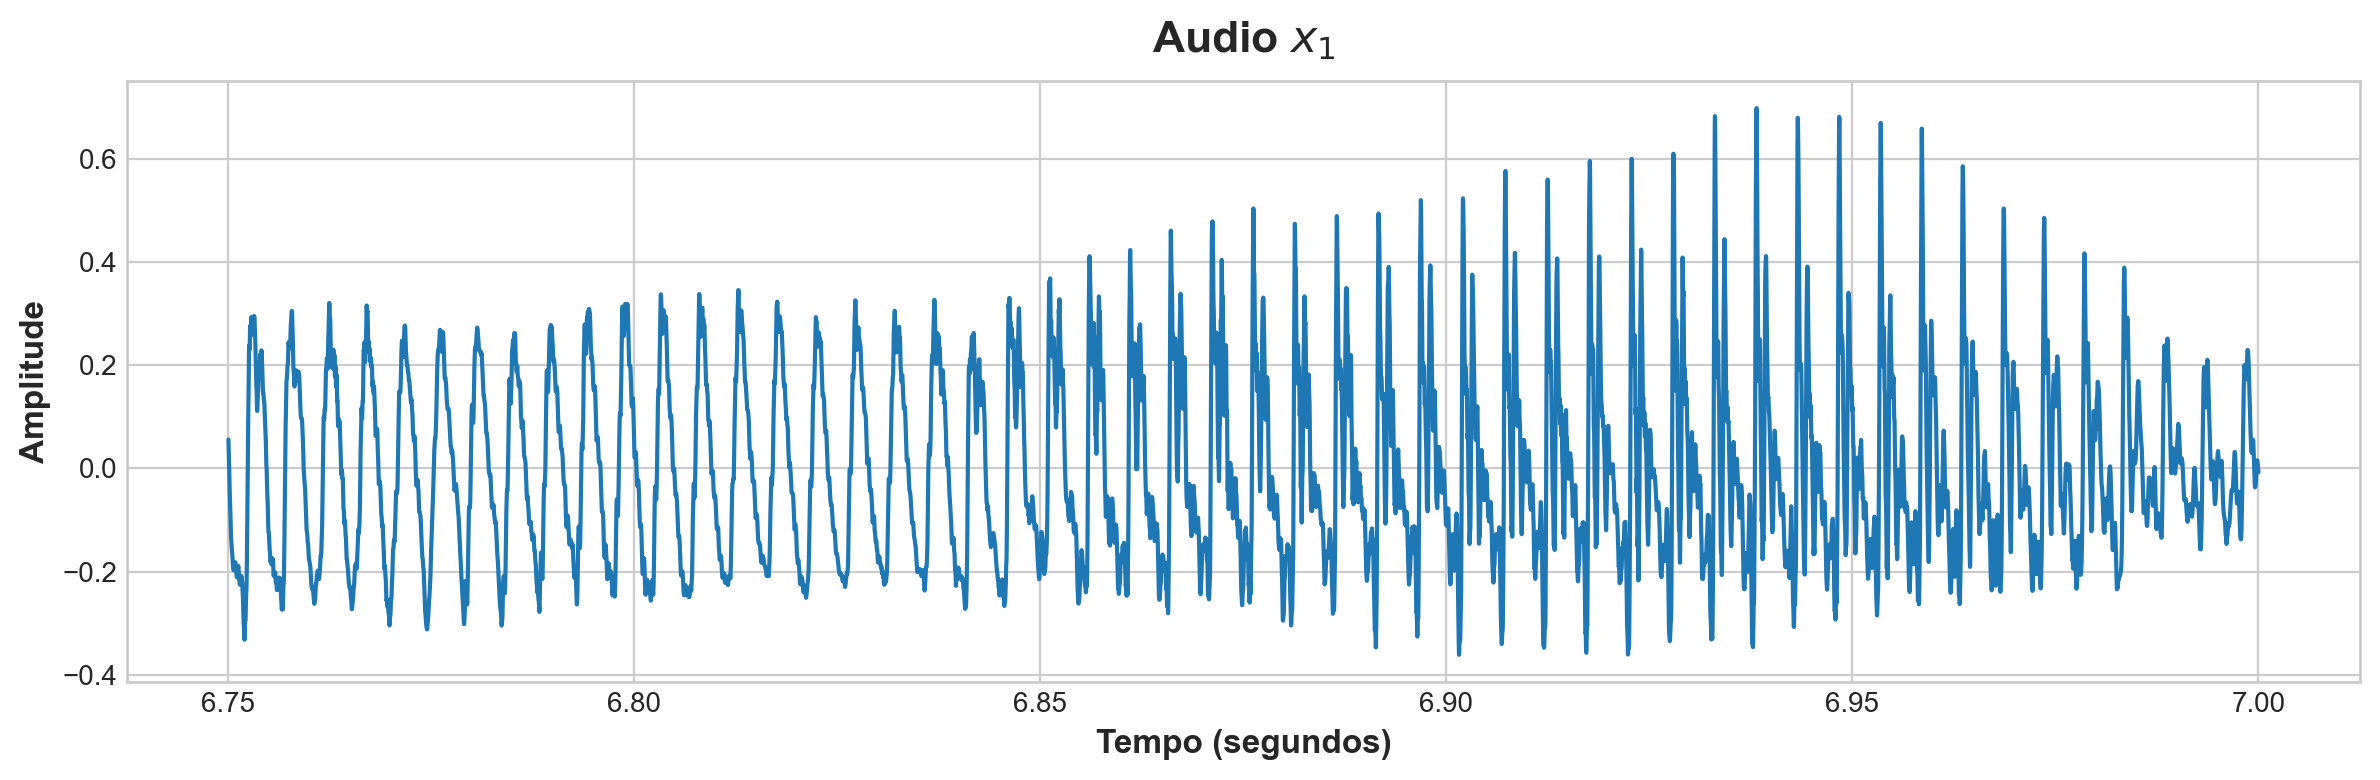

In [19]:
t = np.linspace(6.75, 7, int(fs*(7 - 6.75)))


plt.plot(t, x1[int(6.75*fs):int(7*fs)])
plt.title(r'Audio $x_1$')
plt.xlabel('Tempo (segundos)')
plt.ylabel('Amplitude')
plt.show()

AINDA MAIS PERTO!


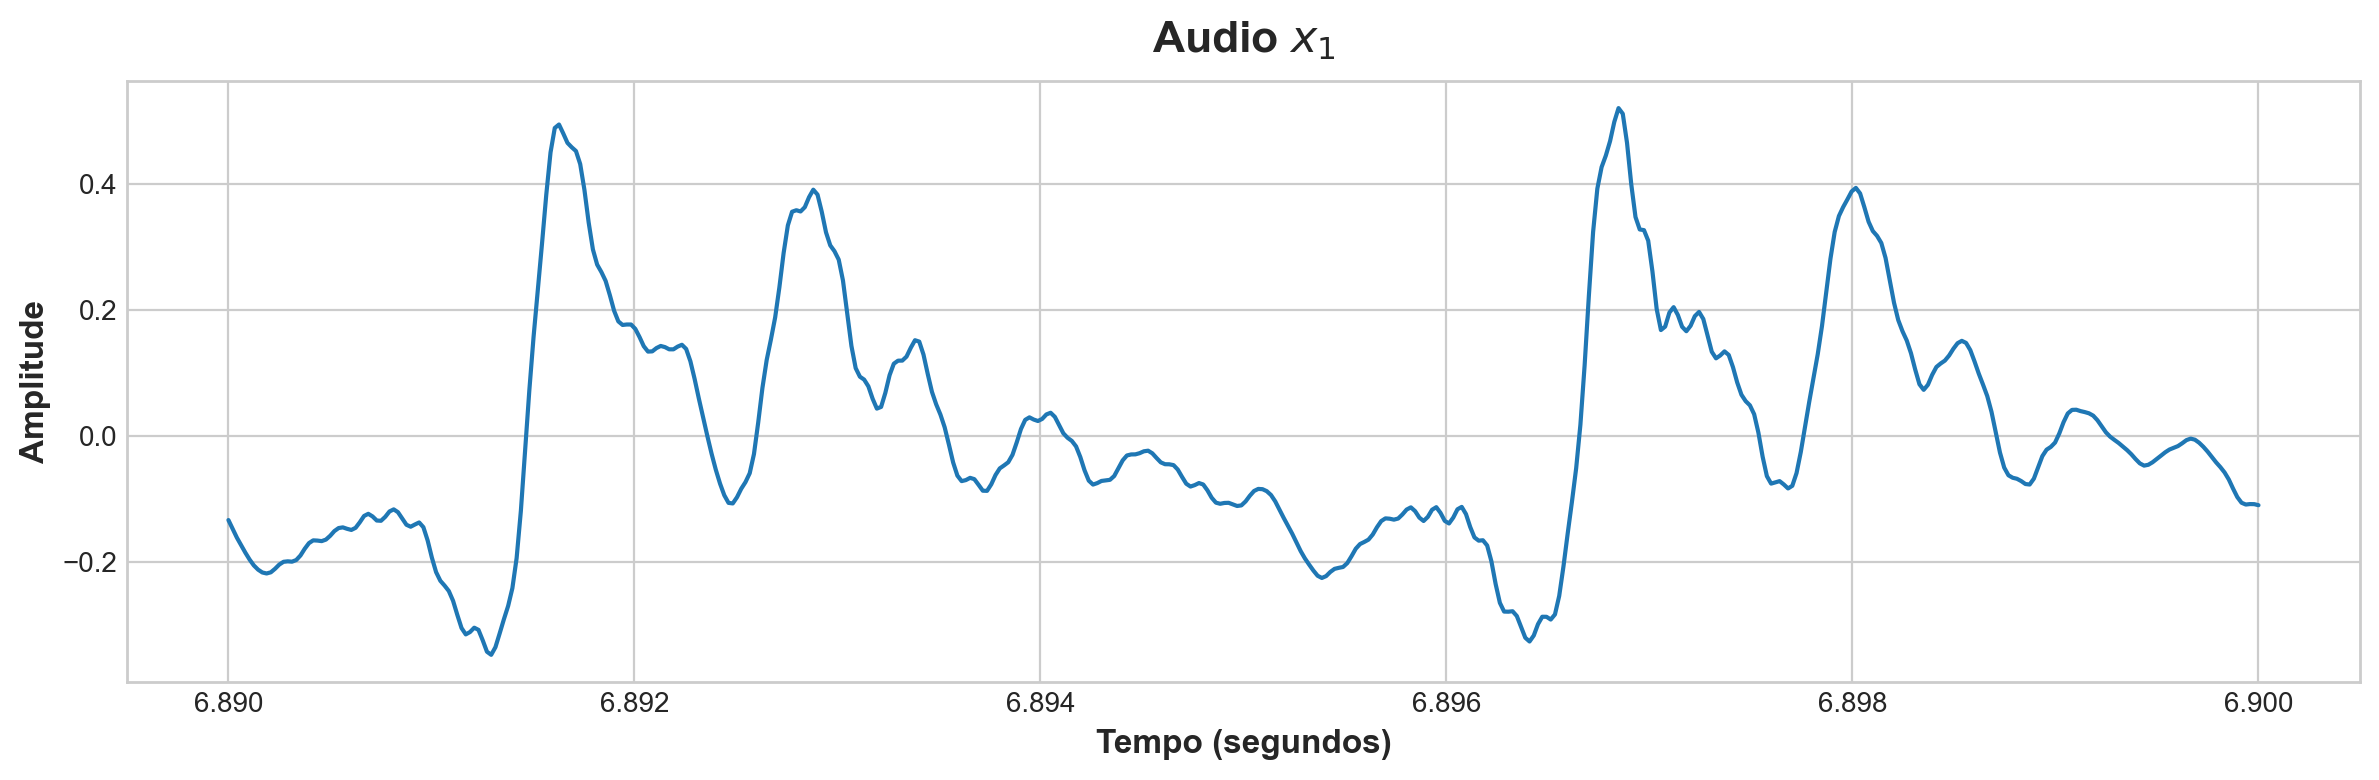

In [20]:
t = np.linspace(6.89, 6.9, int(fs*(6.9 - 6.89)))

plt.plot(t, x1[int(6.89*fs):int(6.9*fs)])
plt.title(r'Audio $x_1$')
plt.xlabel('Tempo (segundos)')
plt.ylabel('Amplitude')
plt.show()

### Domínio do Tempo VS Domínio da Frequência

O eixo $x$ da imagem que você plotou representa o tempo.
Porém, como vimos nas aulas, este não é o único modo de representar um sinal.
Ao invés de mostrar a intensidade do áudio ao longo do tempo, podemos mostrar as frequências que compoem o sinal original.
Deste modo, podemos analisar melhor a informação das características periódicas presentes no áudio em análise.



Agora, vamos relembrar o primeiro GRANDE DESAFIO que tivemos.

TRANSFORMADA DE FOURIER!


In [21]:
data = x1

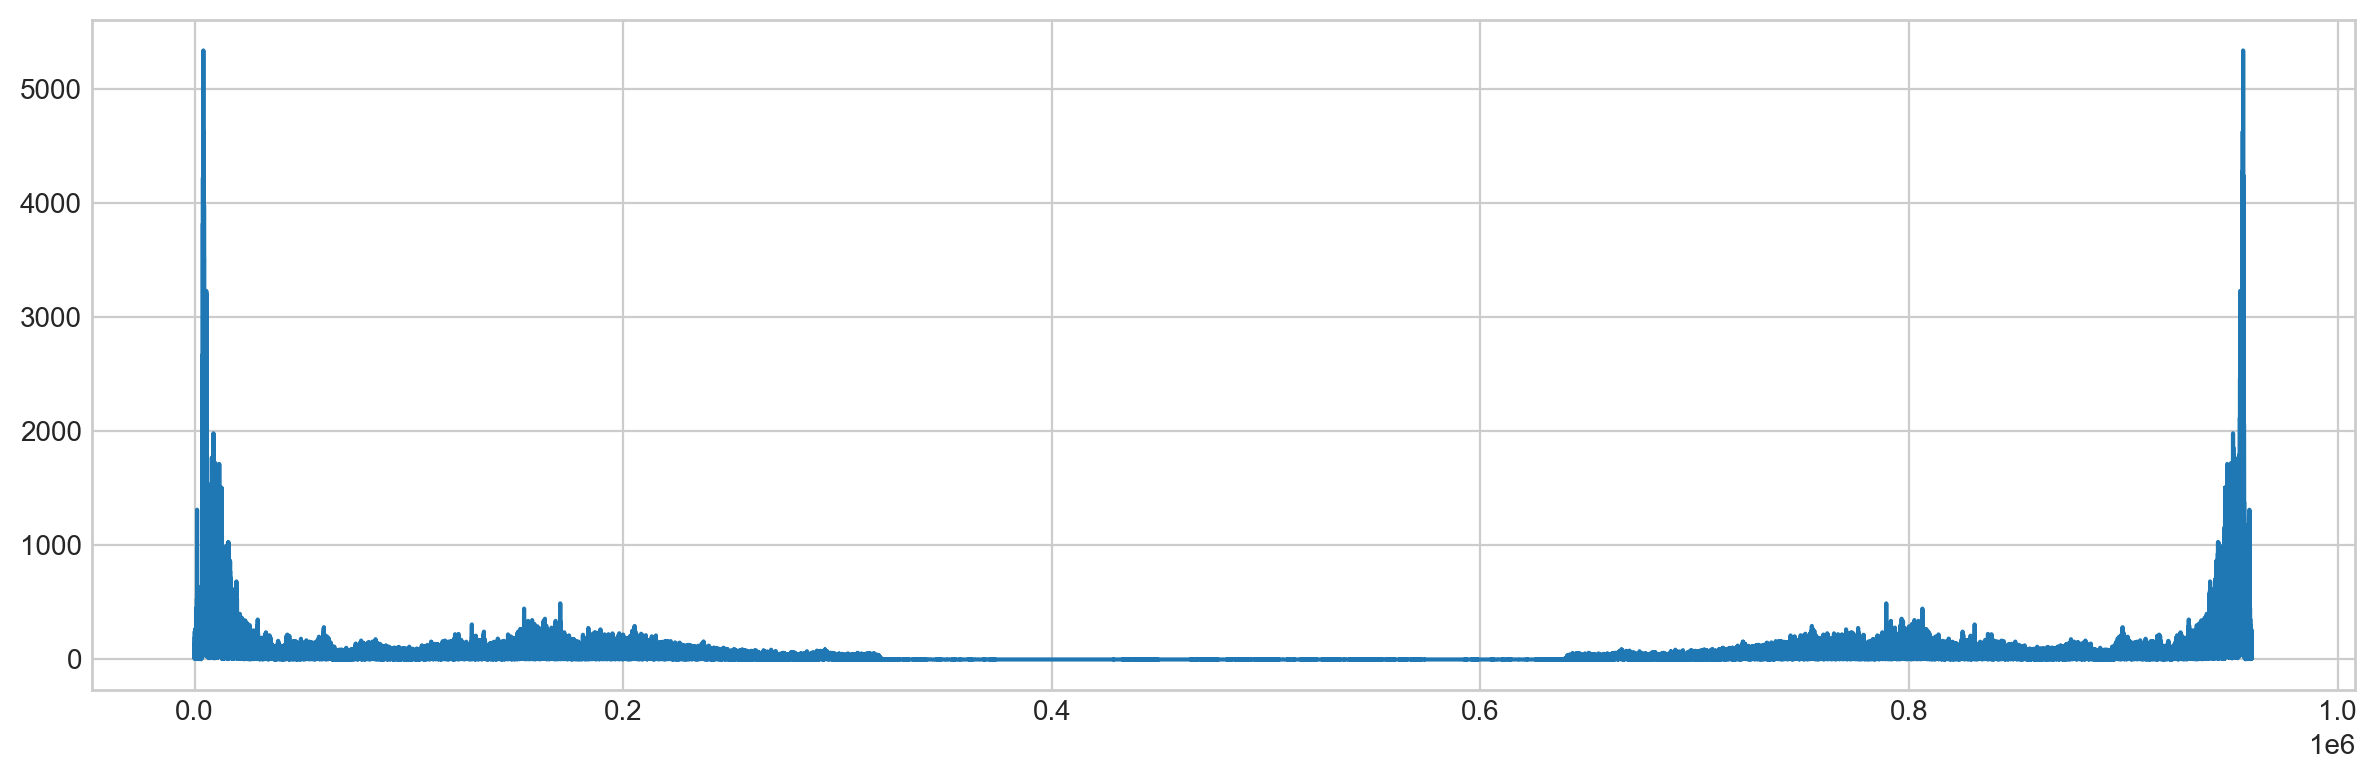

In [22]:
magnitude = np.abs(np.fft.fft(data))
plt.plot(magnitude)

Agora vamos visualizar o sinal em hertz

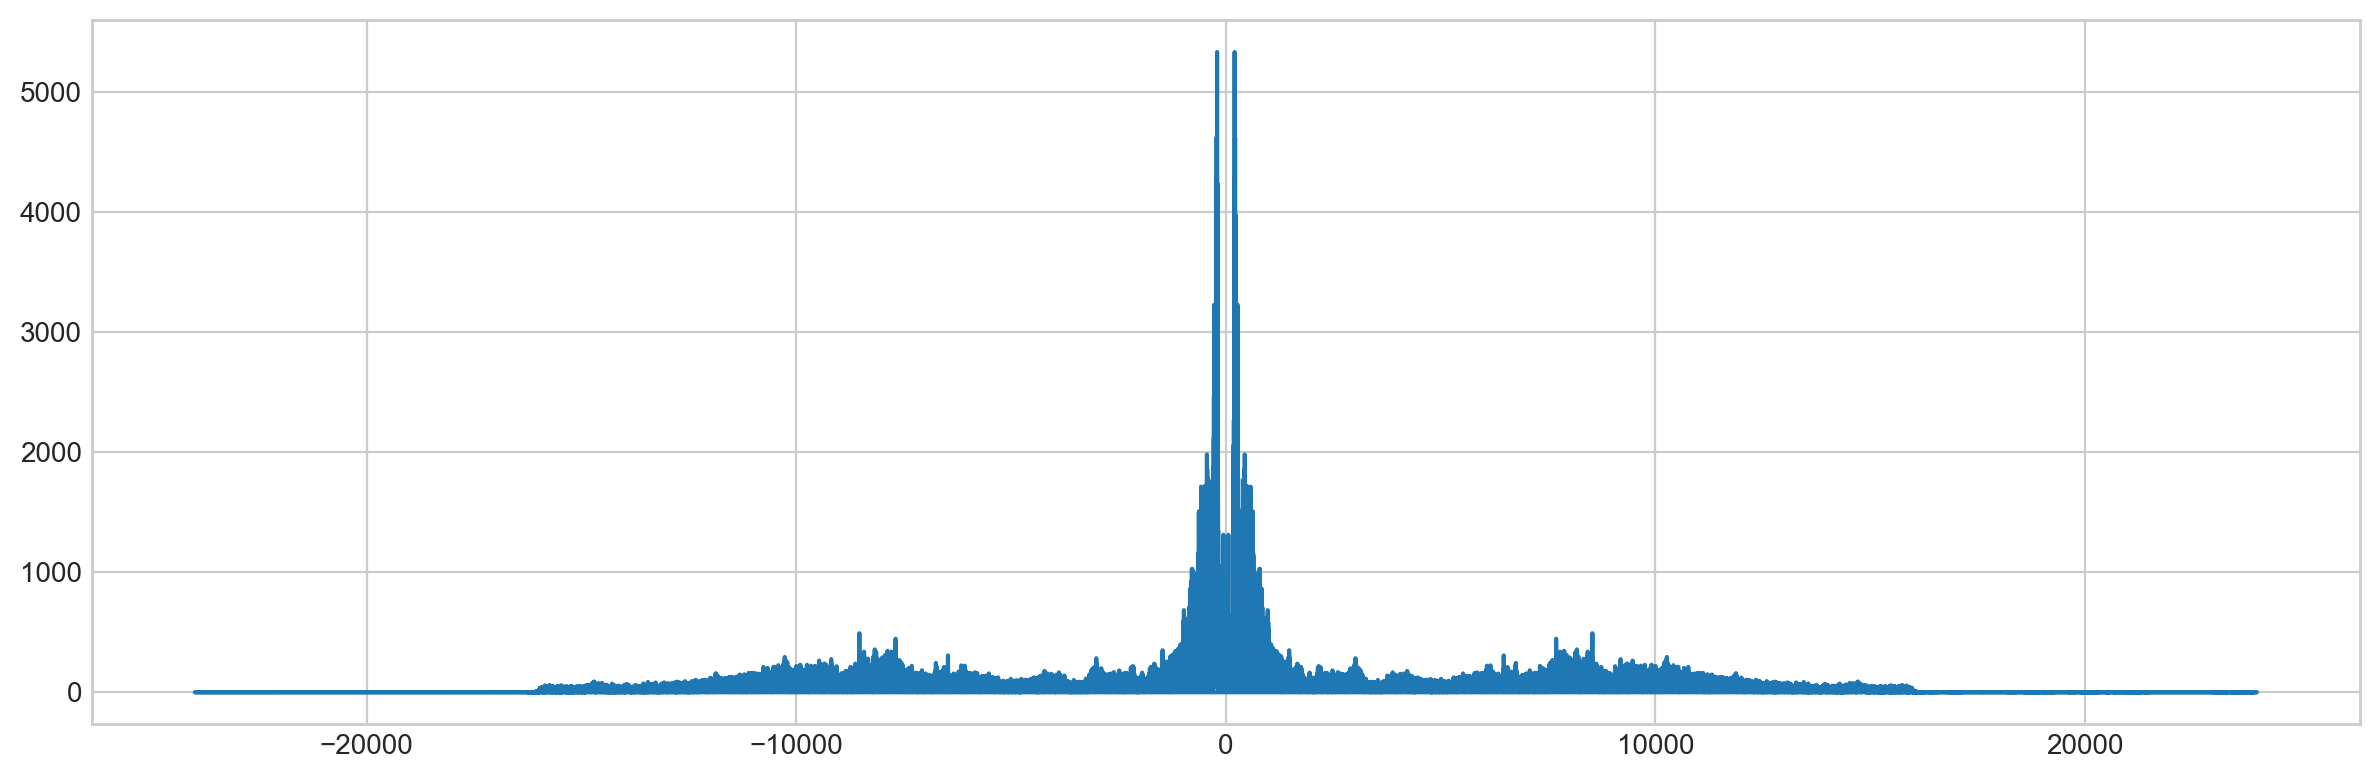

In [23]:
data = x1
freq = np.fft.fftfreq(len(x1), 1/ fs)
magnitude = np.abs(np.fft.fft(data))

plt.plot(freq, magnitude)

Os picos no grafico (maior amplitude) indicam as frequencias que possuem mais influencia na composição final do sinal. Ou seja, as frequencias com maior amplitude possuem maior "significancia" no sinal.

## STFT e Espectogramas

O nosso SEGUNDO GRANDE DESAFIO, vamos ver como ficam nossos áudios aplicado a ele...

In [24]:
# Obter STFT e plotar
def STFT(sinal, tamanho_janela=256, tamanho_passo=128):
    '''
        Calcula a STFT de um sinal.
        Parâmetros:
        - sinal: np.array
            O sinal de entrada.
        - tamanho_janela: int
            Tamanho da janela para cada segmento.
        - tamanho_passo: int
            Número de amostras entre frames sucessivos.
        Retorna:
        - matriz_stft: np.array
            Matriz contendo os coeficientes STFT.
    '''
    num_amostras = len(sinal)
    num_janelas  = 1 + (num_amostras - tamanho_janela) // tamanho_passo

    # Prepara a função de janela (janela de Hann neste caso)
    janela = np.hanning(tamanho_janela)

    # Inicializa a matriz STFT
    matriz_stft = np.zeros((num_janelas, tamanho_janela // 2 + 1), \
                           dtype=np.complex128)

    # Calcula a STFT
    for k in range(num_janelas):
        inicio = k * tamanho_passo
        fim = inicio + tamanho_janela
        segmento = sinal[inicio:fim]

        # Aplica a função de janela
        segmento_janelado = segmento * janela

        # Calcula a FFT
        resultado_fft = np.fft.fft(segmento_janelado)

        # Armazena apenas as frequências não negativas (até a frequência de Nyquist)
        matriz_stft[k, :] = resultado_fft[:tamanho_janela // 2 + 1]

    return abs(matriz_stft)


def plot_spectrogram(sinal, fs, titulo, tamanho_janela=256, tamanho_passo=128):
    # Calcular espectrograma
    spec_signal = STFT(sinal, \
                       tamanho_janela=tamanho_janela, \
                       tamanho_passo=tamanho_passo)

    # Calcular shape do plot
    stft_signal_shape = spec_signal.T.shape
    print(stft_signal_shape)

    # Determinar tempo do audio e frequência máxima
    audio_duration = len(sinal)/fs
    window_size = (stft_signal_shape[0] - 1)*2
    max_freq = np.fft.fftfreq(window_size, 1 / fs)[window_size// 2 - 1]

    # Determinar eixos de tempo e frequencia
    time_values = np.linspace(0, audio_duration, stft_signal_shape[1])
    frequency_values = np.linspace(0, max_freq, stft_signal_shape[0])

    # Criar mapa
    heatmap = sns.heatmap(spec_signal.T, cmap = 'viridis')

    # Inverter o mapa
    heatmap.invert_yaxis()

    # Adicione rótulos aos eixos
    plt.title('Espectrograma do Sinal')
    plt.title(titulo)
    plt.ylabel('Frequência (Hz)')
    plt.xlabel('Tempo (s)')

    # Setar eixos
    plt.xticks(np.arange(0, stft_signal_shape[1], step=stft_signal_shape[1] // 8), \
               labels=np.around(time_values[::stft_signal_shape[1] // 8], decimals=2), \
               rotation=45)
    plt.yticks(np.arange(0, stft_signal_shape[0], step=stft_signal_shape[0] // 8), \
               labels=np.around(frequency_values[::stft_signal_shape[0] // 8], decimals=2))
    plt.show()

In [25]:
data1 = x1
data2 = x2
data3 = x3

data1_F = data1[0: len(data1) //2]
data2_F = data1[0: len(data2) //2]
data3_F = data1[0: len(data3) //2]

data1_V = data1[len(data1)//2: -1]
data2_V = data1[len(data2)//2: -1]
data3_V = data1[len(data3)//2: -1]

(129, 3749)


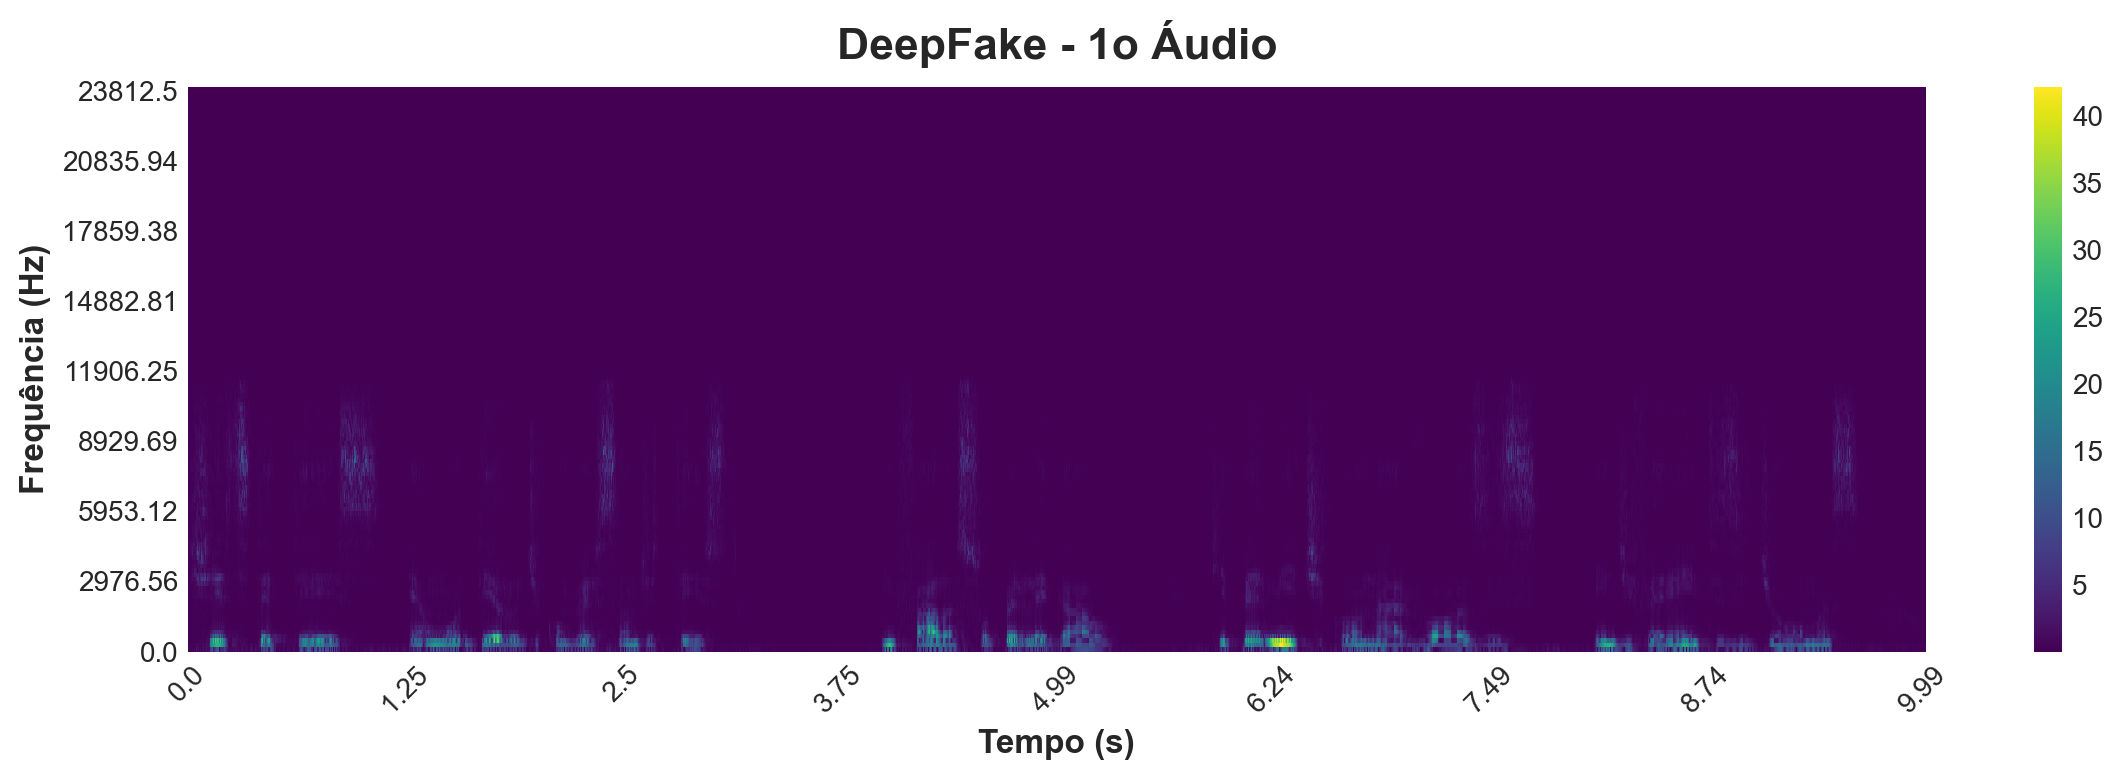

In [26]:
plot_spectrogram(data1_F, fs, "DeepFake - 1o Áudio")


(129, 3748)


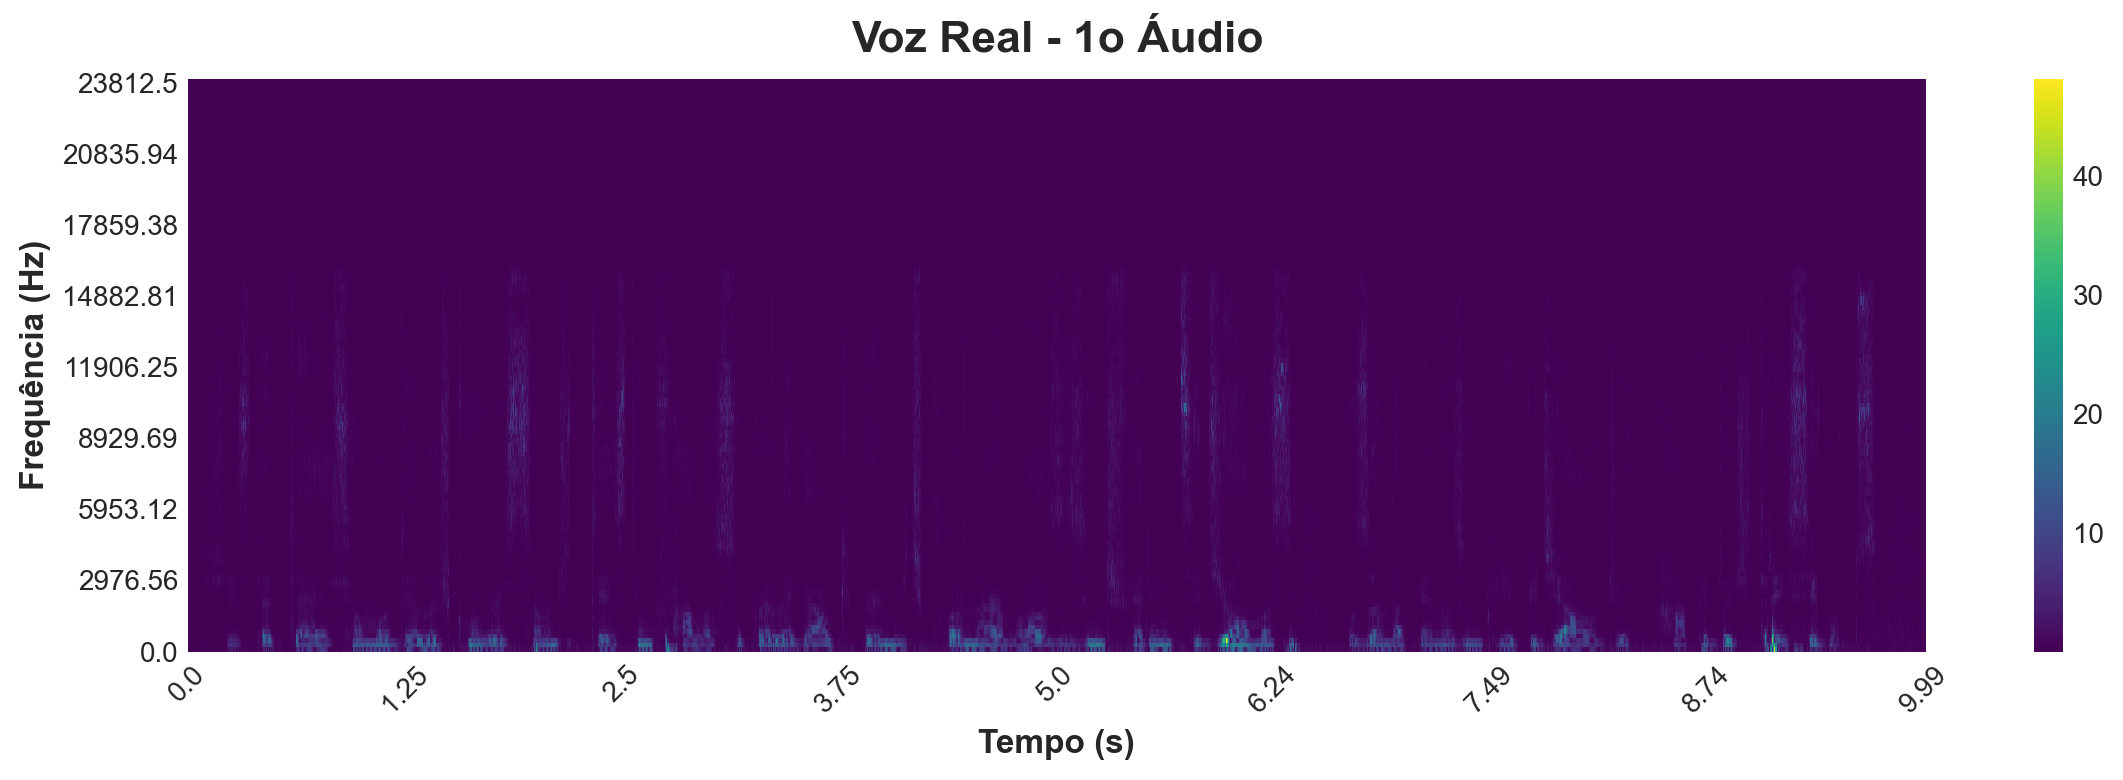

In [27]:
plot_spectrogram(data1_V, fs, "Voz Real - 1o Áudio")

## Processamento dos dados

### Média móvel (filtro passa-baixo)

A média móvel é um **filtro de sinal** usado para suavizar dados. Ela se calcula com base na média de uma certa janela temporal (geralmente chamada de período) e movendo ou deslizando essa janela ao longo da toda uma série temporal.

O algoritmo de média móvel também é conhecido como **filtro passa-baixo** que, como o nome sugere, só deixa passar as frequências mais baixas de um sinal que, em outras palavras, equivale a eliminar o conteúdo de alta frequência!

In [51]:
# def media_movel(signal, window_size):
#     weights = np.repeat(1.0, window_size) / window_size
#     moving_average = np.convolve(signal, weights, mode='same')

#     return moving_average

Aqui usamos apenas a media movel

In [52]:
# amostra = x1[1000:5000]

# md = media_movel(amostra, 200)

# plot_2_figures(amostra, md)

Percebemos que existe uma "suavização" do sinal

## Modelo

E finalmente, vamos ao modelo!

Montagem do dataset:

Montamos um dataset com janelas de tempo de tamanho fixo e label binária ($1$ para *"Voz Real"* e $0$ para *"Voz DeepFake"*).
Utilize os 3 arquivos de sinais recebidos.

Dividimos em várias pequenas janelas e nelas aplicamos a dft e stft, gerando assim, 2 parametros para cada amostra.

In [28]:
# Processamento das amostras com FFT e STFT
a = []  # Armazena os dados processados por FFT
t = []  # Rótulos
X_spec = []  # Armazena os dados processados por STFT

amostras = 2000  # Tamanho das amostras para FFT
for i in range(0, 50000 - amostras - 1, 1000):
    for data, label in [(data1_F, 0), (data1_V, 1), (data2_F, 0), (data2_V, 1), (data3_F, 0), (data3_V, 1)]:
        # Processamento FFT
        segmento_fft = np.abs(np.fft.fft(data[i:i+amostras]))
        a.append(segmento_fft)
        t.append(label)

        # Processamento STFT
        spec_signal = STFT(segmento_fft)
        X_spec.append(spec_signal.flatten())  # Achata o resultado da STFT para armazenamento linear

# Criação do DataFrame
df = pd.DataFrame({'fft': a, 'stft': X_spec, 'Target': t})

In [29]:
df

fft  \
0    [0.216766357421875, 3.7459387425026636, 0.9366...   
1    [0.504547119140625, 0.5893447523470898, 1.0654...   
2    [0.216766357421875, 3.7459387425026636, 0.9366...   
3    [0.504547119140625, 0.5893447523470898, 1.0654...   
4    [0.216766357421875, 3.7459387425026636, 0.9366...   
..                                                 ...   
283  [2.371978759765625, 3.980379790264743, 1.74483...   
284  [3.714752197265625, 2.9881604036214333, 1.1581...   
285  [2.371978759765625, 3.980379790264743, 1.74483...   
286  [3.714752197265625, 2.9881604036214333, 1.1581...   
287  [2.371978759765625, 3.980379790264743, 1.74483...   

                                                  stft  Target  
0    [303.0263126009918, 216.5157199036886, 81.0191...       0  
1    [6.25878060823589, 3.134693755501663, 0.437682...       1  
2    [303.0263126009918, 216.5157199036886, 81.0191...       0  
3    [6.25878060823589, 3.134693755501663, 0.437682...       1  
4    [303.0263126009918, 216.5157199036886, 81.0191...       0  
..                                                 ...     ...  
283  [142.6342736114309, 91.51422998351372, 56.4893...       1  
284  [77.18832353625925, 30.965912693664993, 9.5495...       0  
285  [142.6342736114309, 91.51422998351372, 56.4893...       1  
286  [77.18832353625925, 30.965912693664993, 9.5495...       0  
287  [142.6342736114309, 91.51422998351372, 56.4893...       1  

[288 rows x 3 columns]

**Notas importantes:**
- Para a montagem do dataset, lembrem que há várias técnicas de amostragem de dados. Como vocês devem selecionar janelas de tempo dos áudios para criar um dataset, pensem em como coletar essas janelas. Serão janelas aleatórias? Serão janelas igualmente espaçadas? Algumas técnicas que aprendemos em estatística são amostragem simples, estratificada, sistemática e etc. (Não precisa detalhar qual método vocês vão utilizar, apenas pensem em como montar um bom dataset que represente os áudios)

- Não pegue janelas de tempo muito grandes (recomendo janelas com menos de 0.1 segundo). Caso a janela seja grande, na hora de montar o dataset pode haver muita sobreposição de dados (parte de uma janela está em outra janela do dataset) e isso pode levar em overfitting.

**Ajudinha**

Como lembrar de sintaxe pode ser meio difícil (todo mundo usa a chat para essas coisas hoje em dia) aqui está alguns exemplos de códigos que podem auxiliar vocês:

- Criar modelo

In [30]:
# Preparação das variáveis X e y
X_fft = df['fft'].tolist()  # Converte a coluna 'Amostra' para uma lista de arrays FFT
X_stft = df['stft'].tolist()  # Converte a coluna 'stft' para uma lista de arrays STFT achatados
y = df['Target'].values  # Extrai os valores da coluna 'Target' como um array numpy

# Combinando FFT e STFT em um único array numpy para X
# Supondo que você queira usar tanto os dados FFT quanto os dados STFT como características
X = np.hstack((X_fft, X_stft))  # Isso presume que X_fft e X_stft são listas de arrays do mesmo tamanho


# Se X_fft e X_stft não são simplesmente listas de números, mas sim listas de arrays,
# você precisará de uma etapa adicional para transformá-los em arrays adequados para modelagem.
# Isso pode envolver, por exemplo, garantir que todos os arrays tenham o mesmo tamanho e achatá-los.


In [36]:
from sklearn.model_selection import train_test_split

# Aqui X e y vocês teriam que criar para posteriormente separar entre treino e teste
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.10, random_state=42)

In [37]:
'''
Regressão Logística é um modelo simples e bom para este desafio,
mas sinta-se livre para escolher outros caso queira
'''

from sklearn.linear_model import LogisticRegression

model = LogisticRegression() # Inicializar o modelo
model.fit(X_train, y_train) # Treinar o modelo

y_pred = model.predict(X_test) # Testar o modelo

Acurácia: 1.0
Matriz de Confusão:
[[13  0]
 [ 0 16]]
Precisão: 1.0
Recall: 1.0
F1-score: 1.0
AUC: 1.0


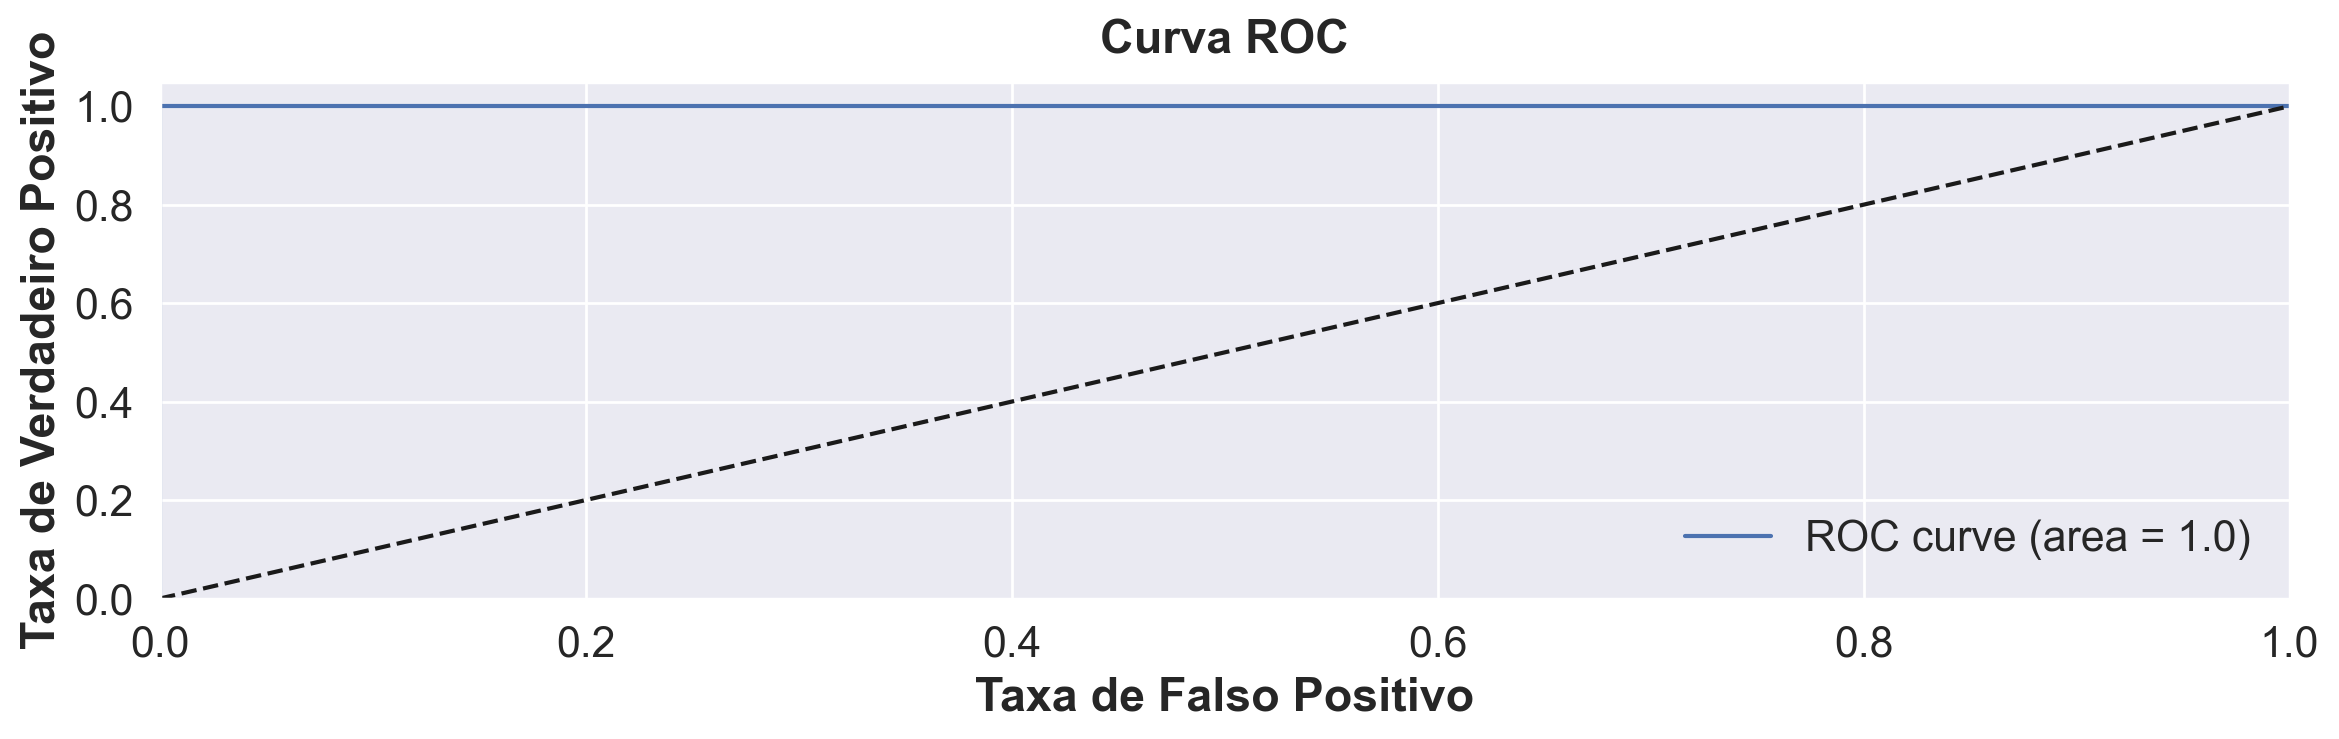

In [38]:
from sklearn.metrics import accuracy_score, confusion_matrix, precision_score, recall_score, f1_score, roc_auc_score, roc_curve
import matplotlib.pyplot as plt

# Acurácia
accuracy = accuracy_score(y_test, y_pred)
print(f"Acurácia: {accuracy}")

# Matriz de Confusão
conf_matrix = confusion_matrix(y_test, y_pred)
print(f"Matriz de Confusão:\n{conf_matrix}")

# Precisão
precision = precision_score(y_test, y_pred)
print(f"Precisão: {precision}")

# Revocação (Recall)
recall = recall_score(y_test, y_pred)
print(f"Recall: {recall}")

# F1-score
f1 = f1_score(y_test, y_pred)
print(f"F1-score: {f1}")

# Calculando a probabilidade das previsões para usar na curva ROC e no cálculo da AUC
y_pred_prob = model.predict_proba(X_test)[:, 1]

# AUC
auc = roc_auc_score(y_test, y_pred_prob)
print(f"AUC: {auc}")

# Curva ROC
fpr, tpr, thresholds = roc_curve(y_test, y_pred_prob)
plt.figure()
plt.plot(fpr, tpr, label=f'ROC curve (area = {auc})')
plt.plot([0, 1], [0, 1], 'k--')  # Linha de chance
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('Taxa de Falso Positivo')
plt.ylabel('Taxa de Verdadeiro Positivo')
plt.title('Curva ROC')
plt.legend(loc="lower right")
plt.show()


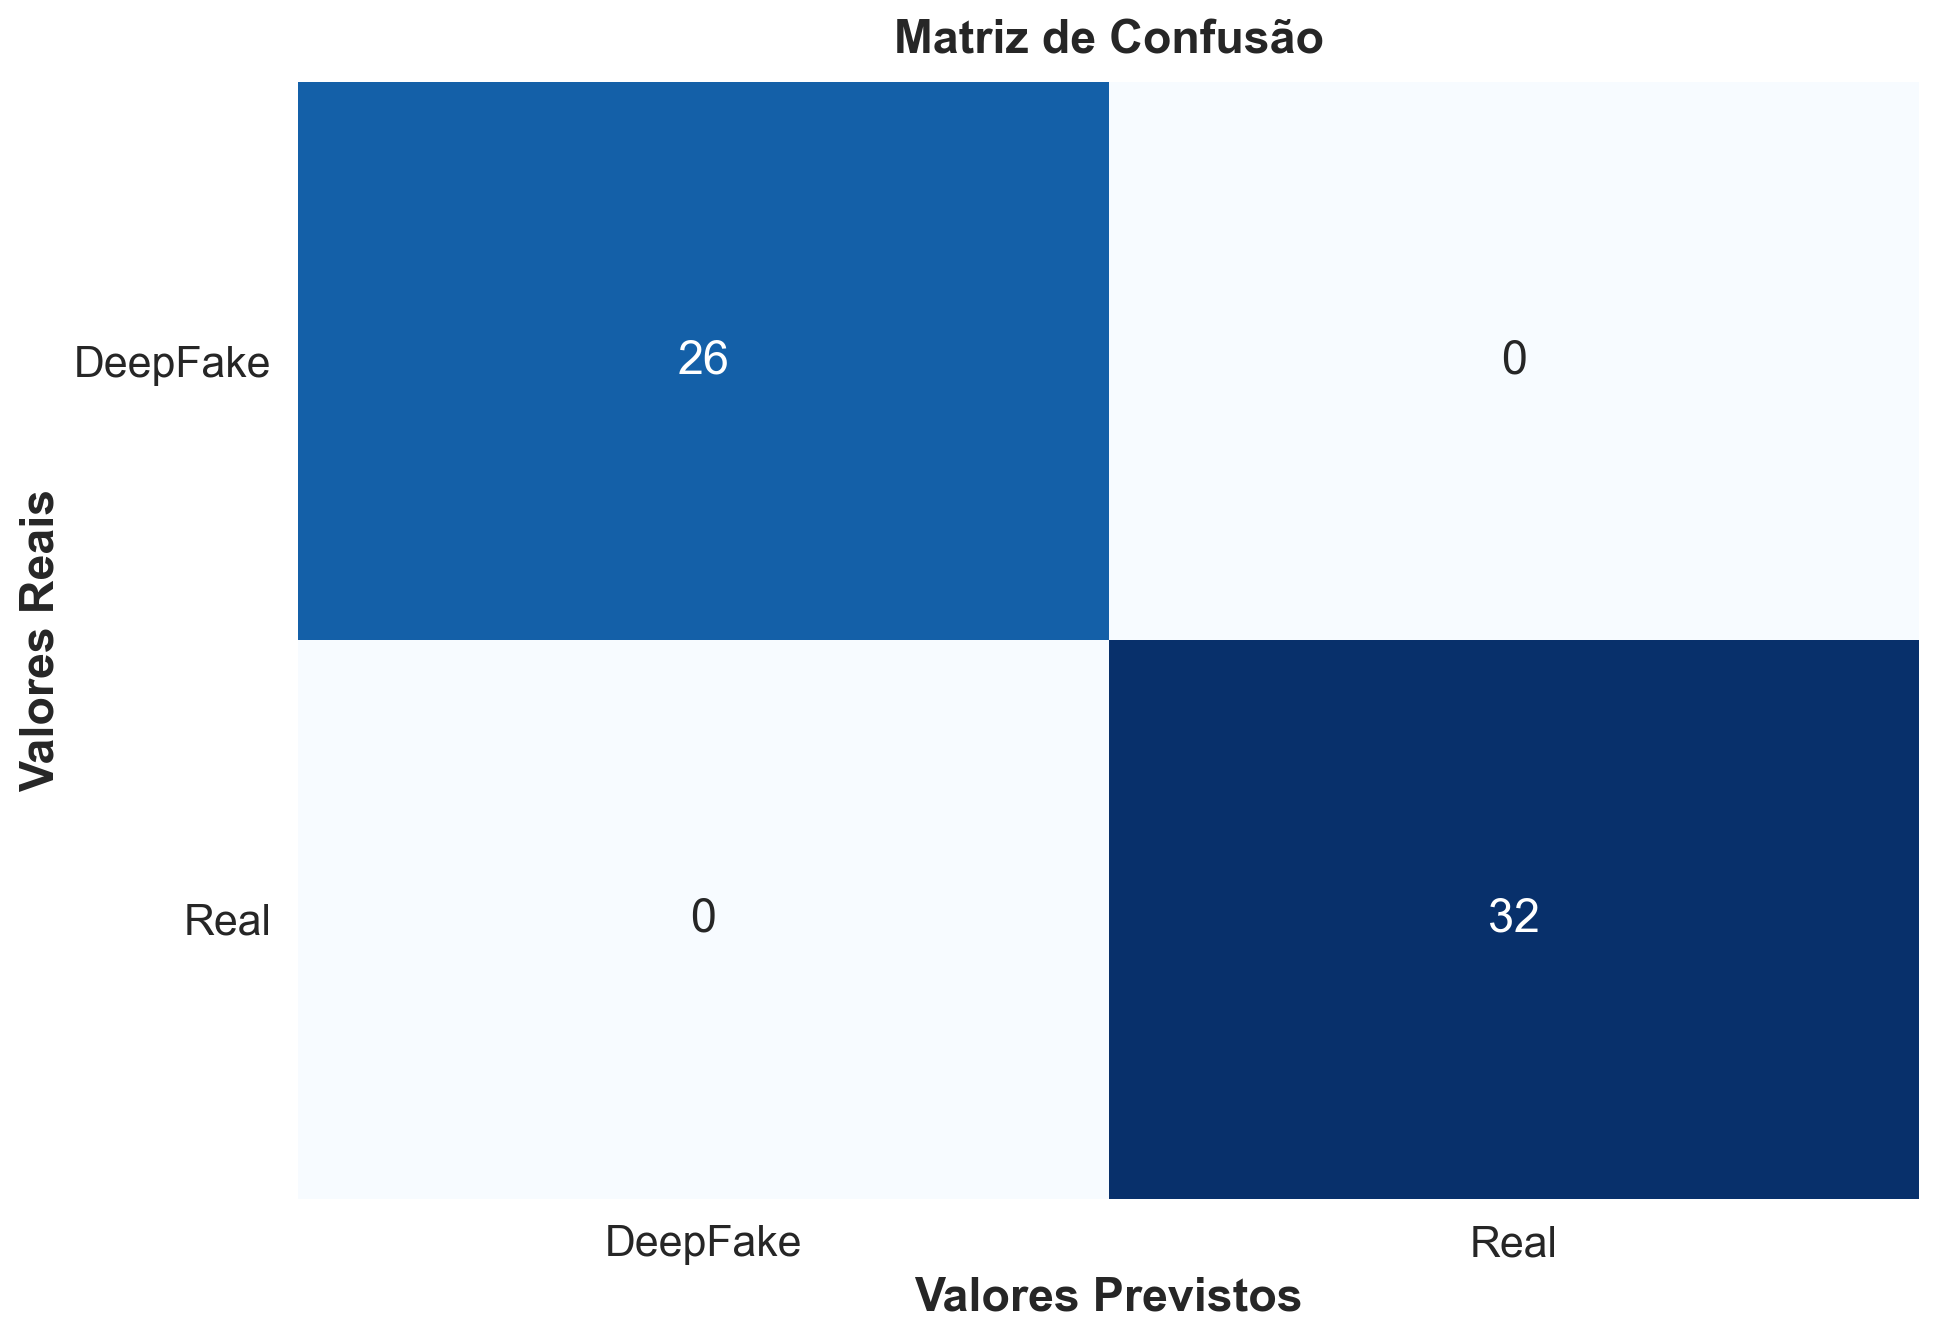

In [34]:
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import confusion_matrix

# Primeiro, calculamos a matriz de confusão
conf_matrix = confusion_matrix(y_test, y_pred)

# Agora, vamos plotá-la com Seaborn
plt.figure(figsize=(10, 7))
sns.set(font_scale=1.4)  # Ajusta o tamanho da fonte
sns.heatmap(conf_matrix, annot=True, fmt='g', cmap='Blues', cbar=False)

# Adicionando títulos e rótulos
plt.xlabel('Valores Previstos')
plt.ylabel('Valores Reais')
plt.title('Matriz de Confusão')
plt.xticks(ticks=[0.5, 1.5], labels=['DeepFake', 'Real'])  # Ajusta conforme as classes do seu modelo
plt.yticks(ticks=[0.5, 1.5], labels=['DeepFake', 'Real'], rotation=0)
plt.show()


Portanto, vemos que conseguimos treinar um modelo muito bom para resolver o nosso problema!

Mas é claro que essa métricas tão altas, provavelmente, se devem a a falta de variabilidae, isto é, nos baseamos nos áudios de apenas uma pessoa e nos áudios gerados de um só modelo, XTTS.